# Generation of figure 3
Tim Tyree<br>
1.3.2022

In [1]:
# TODO: simplify initialization
from scipy.optimize import minimize
from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt, numpy as np
from mpltools import annotation
import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats

#for particle params to MSR generating functional
from scipy.signal import savgol_filter
import dask.bag as db
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

#optional
import cupy as cp
cp.random.seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#reset matplotlib
mpl.rcParams.update(matplotlib.rcParamsDefault)

# DONE: fit annihilation rates of the interacting inverse-powerlaw particle model to those of the full models
- method of fit: minimization of mean squared error of the powerlaw fits of the particle model to those of the full models
- method of minimization: Nelder-Mead minimization

In [3]:
#recall results from tables in the main mansucript
wjr=recall_powerlaw_fits_to_full_models()
interp=recall_particle_model_interp()
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

estimated runtime is ~20 seconds for 17988 training samples...
number of training examples is 17988....
training complete!


In [4]:
#fit the particle model to the luo-rudy model
dict_out_lr=PlotParticlModelAnnihilationRateFit(a=a_hat_LR,D=D_hat_LR,wjr=wjr,interp=interp,
    ax=None,model_name='lr_pbc',c='C1')

a=8.595, D=0.586055, r=0.10413888309470609, kappa=559.500160485693, rmse=0.028075538795257697


In [5]:
#fit the particle model to the fenton-karma model
dict_out_fk=PlotParticlModelAnnihilationRateFit(a=a_hat_FK_vlong,D=D_hat_FK,wjr=wjr,interp=interp,
    ax=None,model_name='fk_pbc',c='C0')

a=1.604153, D=0.365238, r=0.06045948522530842, kappa=495.2658318951493, rmse=0.006797222653889483


In [6]:
#recall ^these fits from lib
a,D,r,kappa,rmse=recall_particle_parameter_fits('luorudy')
print(f"a={a},    D={D}, r={r}, kappa={kappa},  rmse={rmse}")
a,D,r,kappa,rmse=recall_particle_parameter_fits('fentonkarma')
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

a=8.595,    D=0.586055, r=0.10413888309470609, kappa=559.500160485693,  rmse=0.028075538795257697
a=1.604153, D=0.365238, r=0.06045948522530842, kappa=495.2658318951493, rmse=0.006797222653889483


# scratchwerk

In [7]:
# #GOAL(Fig. 3 in this ipynb)
# #DONE(Fig. 3): plot 
# #FK fit of particle model
# a=1.604153, D=0.365238, r=0.06045948522530842, kappa=495.2658318951493, rmse=0.006797222653889483
# #LR fit of particle model
# a=8.595, D=0.586055, r=0.10413888309470609, kappa=559.500160485693, rmse=0.028075538795257697
#TODO: plot each figure panel individually

In [8]:
#msr from the particle model
# npz_dir_FK='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_7.3923_D_0.365238.npz'#csv'
#msr from the full model
# msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'

#msr from the particle model
# npz_dir_LR='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_8.595_D_0.586055.npz'#.csv'


# DONE(Fig. 3.A): quick mockup of barchart 
quick mockup of barchart showing durations (and bootstrapped 95% CI) of (i) mean period estimates and (ii) mean lifetime estimates for (blue) the Fenton-Karma model and (orange) the Luo-Rudy model

In [9]:
#reset matplotlib
mpl.rcParams.update(matplotlib.rcParamsDefault)

In [10]:
#TODO: compute the kinematic periods from the full models
meanT_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/luorudy_mean_kinematic_periods.npz'
meanT_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/fentonkarma_mean_kinematic_periods.npz'
# np.mean(meanT_values)

In [11]:
#TODO: copy & paste barcharts from neurophysics
#TODO: copy lifetimes from .xlsx
#TODO: estimate periods from plot and give reasonable 95% CI estimates
#TODO: copy & paste ^that to .odg as a re-first-draft of Fig. 3.A
#TODO: move on to my sketch of Fig. 3.B
# TODO(later): measure the period precisely
mean_lst=[90,100,310.057,82.7333]
Delta_mean_lst=[10,10,3.5354,0.9154]
# Nobs_lst=[43306,10362,43306,10362]#GUESSED PERIOD SAMPLE SIZES
Nobs_lst=[4330,1036,4330,1036]#GUESSED PERIOD SAMPLE SIZES
# Nobs_lst=[??,??,43306,10362]

In [12]:
#perform student t-tests for significantly different average values

In [13]:
stat,p=stats.ttest_ind_from_stats(mean1=mean_lst[2], std1=Delta_mean_lst[2]/1.96*np.sqrt(Nobs_lst[2]), nobs1=Nobs_lst[2],
                           mean2=mean_lst[3], std2=Delta_mean_lst[3]/1.96*np.sqrt(Nobs_lst[3]), nobs2=Nobs_lst[3])
print(f"a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p={p}.")

a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p=0.0.


In [14]:
stat,p=stats.ttest_ind_from_stats(mean1=mean_lst[0], std1=Delta_mean_lst[0]/1.96*np.sqrt(Nobs_lst[0]), nobs1=Nobs_lst[0],
                           mean2=mean_lst[1], std2=Delta_mean_lst[1]/1.96*np.sqrt(Nobs_lst[1]), nobs2=Nobs_lst[1])
print(f"a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p={p}.")

a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p=0.35119444375871434.


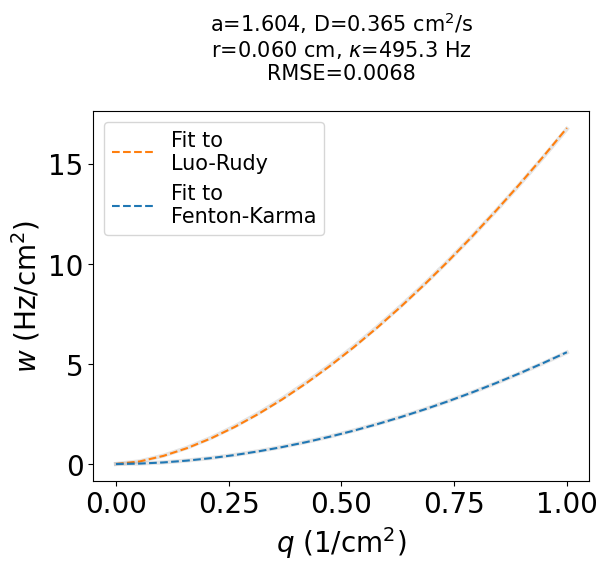

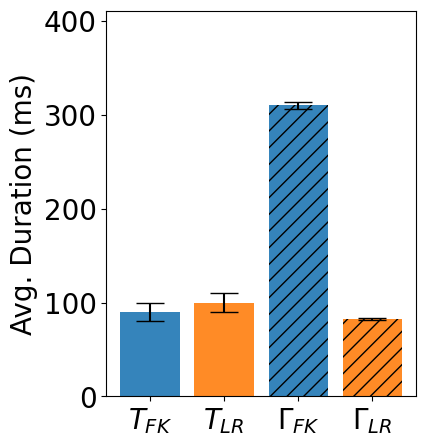

In [15]:
bar_height_values=np.array(mean_lst)
Delta_bar_height_values=np.array(Delta_mean_lst)
color_lst=['C0','C1','C0','C1']
bar_label_lst=[r'$T_{FK}$',r'$T_{LR}$',r'$\Gamma_{FK}$',r'$\Gamma_{LR}$']
# hatch: {'/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
hatch_values=np.array(['','','//','//'])
# bar_label_lst=['Audio-Only\n\n\n','Match\n\n\n','Mismatch\n\n\n','Video-Only\n\n\n']
ylabel='Avg. Duration (ms)'#\nwith Preferred Modality'
fig,ax=plt.subplots(figsize=(4,5))
ax.bar(bar_label_lst,bar_height_values,hatch=hatch_values,yerr=Delta_bar_height_values,alpha=0.9,color=color_lst,capsize=10)
# ax.errorbar(bar_label_lst[0],bar_height_values[0],Delta_bar_height_values[0],alpha=0.9,color=color_lst[0])
format_plot(ax=ax,xlabel='',ylabel=ylabel)
# title=''
# ax.set_title(title,fontsize=18)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylim([0,410])
# plt.xticks(rotation=90)
# plt.xticks(rotation=0)
# plt.xticks(rotation=-90)
plt.show()

# TODO: dev Fig. 3.B

## generate MSR for the oscillatory model

In [ ]:
include_earliest=False#True#broken?

In [ ]:
#heretim
ahat_long=a_hat_FK_vlong#a_hat_LR_long
#Fenton-Karma
#GOAL: add a reasonable fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)
#DONE: initialize the particle model for the FK model
a=2.4; #2.5?
D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_FK,y_values_FK
# #DONE: initialize the particle model for the LR model
# a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_LR,y_values_LR
T=100#110#140#100#120#180#90#240
D=0.365238#	0.004171	101774+/-103689,0.6,1.5,0.98 # from particle properties spreadsheet
a=1.6
D=ahat_long/2#/1 #/4#/4
a=ahat_long#/2
#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

# initial_phase_orientation=phif
# initial_phase_orientation-=np.pi/2-np.pi# worse/4#/2
initial_phase_orientation+=np.pi/2

num_pairs=10000#1min 30sec: 10+1#400#2min 22sec: 
#before, long runtime
dict_out,position_array = gener_positions_oscillatory_reversed(
            a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation,
            include_earliest=include_earliest,
            period_of_oscillation=T)
print(*dict_out)
positions_out=position_array

#estimated run time: <1 minute
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt

t_values_fk_osc=t_values.copy()
MSR_values_fk_osc=MSR_values.copy()
beep(5)

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 10000)


In [ ]:
#heretim
ahat_long=a_hat_LR_long#a_hat_FK_vlong#
#Luo-Rudy
#runtime was ~40 seconds
#recompute the Luo-Rudy model's fitty for the MSR of the oscillatory model 
#GOAL: add a reasonable fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)
#DONE: initialize the particle model for the FK model
a=2.5; D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_FK,y_values_FK
#DONE: initialize the particle model for the LR model
a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_LR,y_values_LR

#TODO: try to get a reasonable a for LR given D=D_LR
D=0.586055#	0.087553	1871+/-520,0,0.55*,0.89#from particle properties spreadsheet
a=5#too big 8.5#tad small...9#4.5#discontinuous... 5#too small... 3.8
T=120#100#240#120
D=ahat_long/2#/1 #/4
a=ahat_long
#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

initial_phase_orientation=phif
num_pairs=10000#1min 30sec: 10+1#400#2min 22sec: 
#before, long runtime
dict_out,position_array = gener_positions_oscillatory_reversed(
            a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation,
            include_earliest=include_earliest,
            period_of_oscillation=T)

print(*dict_out)
positions_out=position_array

#estimated run time: <1 minute
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt

t_values_lr_osc=t_values.copy()
MSR_values_lr_osc=MSR_values.copy()
beep(5)

In [ ]:
!pwd

In [ ]:
#DONE: save dotted as .npz
msr_osc_fn=f"msr_osc_full.npz"
np.savez_compressed(msr_osc_fn,
                   t_values_fk_osc=t_values_fk_osc,
                   MSR_values_fk_osc=MSR_values_fk_osc,
                   t_values_lr_osc=t_values_lr_osc,
                   MSR_values_lr_osc=MSR_values_lr_osc)
print(f"msr_osc_fn='{os.path.abspath(msr_osc_fn)}'")
assert os.path.exists(msr_osc_fn)

In [20]:
assert not np.isnan(Rsq_values).all()

False

## plot the results

In [21]:
#estimate a_sr expected for this value with a sliding window
msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083

msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms

In [22]:
df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

In [23]:
tmax=300#8#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=8#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.604153+/-0.040173 cm^2/s, tmax=300
a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8


In [ ]:
#heretim
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot fitty
plt.plot(t_values_fk_osc*1e3,MSR_values_fk_osc,':',lw=2,alpha=0.5,c='C0')
plt.plot(t_values_lr_osc*1e3,MSR_values_lr_osc,':',lw=2,alpha=0.5,c='C1')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,180])
plt.ylim([0,3.1])
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
plt.title(title)
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

In [ ]:
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

plt.plot(t_values_fk_osc*1e3,MSR_values_fk_osc,':',lw=2,alpha=0.5,c='C0')
plt.plot(t_values_lr_osc*1e3,MSR_values_lr_osc,':',lw=2,alpha=0.5,c='C1')

#this FAILS to let me change the text displayed...  i must make a triangle and a text box to make the slope's label "4a_FK"
# #mark the slope of ^that line with slope = 4*1.6 (FK) and slope = 4*8.6 (LR)
# x1 = 700
# y1 = 4
# ax=plt.gca()
# annotation.slope_marker(origin=(x1, y1),
#                         slope=4*1.6e-3,#(1.6,1),#1.6,
# #                         invert=True,
# #                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7, "text":'4a'},
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

#format plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1000])
plt.ylim([0,5.1])
# plt.ylim([0,4.1])

plt.show()

In [26]:
#TODO(later?): add a legend that identifies the 3 different classes of curves with black legend markers
# (solid) full model, 
# (dashed) interacting inverse-powerlaw particle model,
# (dotted) oscillatory particle model,

In [27]:
#GOAL: highlight ^this with slopes indicating how ahat is computed 
# #TODO: change label to 4*a
# annotation.slope_marker? #LAME
# matplotlib.text.Text? #object oriented
# matplotlib.patches.Polygon? #object oriented
# #HINT: use ^these two mpl handles to add slopes to indicate 

In [6]:
1.604153/2

0.8020765

In [5]:
Tavg_expected_lr=1e-03/0.095638665 #seconds #N=10, L=5
print(f"Tavg_expected_lr={Tavg_expected_lr} when N=10, L=5")
Tavg_expected_lr=1e-03/0.18501388 #seconds N=16, L=5
print(f"Tavg_expected_lr={Tavg_expected_lr} when N=16, L=5")
# src: src: full_results/data_fig4_vidmar_lr_tt.csv

Tavg_expected_lr=0.0104560221538015 when N=10, L=5
Tavg_expected_lr=0.005404999884333002 when N=16, L=5


## (example msr traces from oscillatory) generate traces of MSR from the oscilatory model that are reasonable guesses for the full models
DONT dev nelder-mead least square fits of the oscillatory model to the MSR of the full models

In [28]:
#GOAL: add a best fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)


#DONE: initialize the particle model for the FK model
a=2.5; D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_FK,y_values_FK
#DONE: initialize the particle model for the LR model
a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_LR,y_values_LR

#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

In [29]:
#     #2 min. runtime?
testing=True
initial_phase_orientation=phif
num_pairs=50#1min 30sec: 10+1#400#2min 22sec: 
if testing:
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    positions_out=position_array
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 50)


In [30]:
#GOAL: add a reasonable fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)
#DONE: initialize the particle model for the FK model
a=2.5; D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_FK,y_values_FK
#DONE: initialize the particle model for the LR model
a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_LR,y_values_LR

#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

initial_phase_orientation=phif
num_pairs=1000#1min 30sec: 10+1#400#2min 22sec: 
#before, long runtime
dict_out,position_array = gener_positions_oscillatory_reversed(
            a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
print(*dict_out)
positions_out=position_array

#estimated run time: <1 minute
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt

t_values_lr_osc=t_values.copy()
MSR_values_lr_osc=MSR_values.copy()
beep(5)

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)


0

In [31]:
#     #2 min. runtime?
testing=True
initial_phase_orientation=phif
num_pairs=200#1min 30sec: 10+1#400#2min 22sec: 
if testing:
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    positions_out=position_array
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 200)


In [32]:
#     #2 min. runtime?
testing=True
initial_phase_orientation=phif
num_pairs=100#1min 30sec: 10+1#400#2min 22sec: 
if testing:
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    positions_out=position_array
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 100)


In [33]:
#TODO: average ^that N=1000 run.
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)

positions_out.shape=(100000, 4, 100)


In [34]:
plt.plot(MSR_values)

In [35]:
MSR_values_high_res=MSR_values.copy()
MSR_values_high_res.shape

(100000,)

positions_out.shape=(100000, 4, 100)


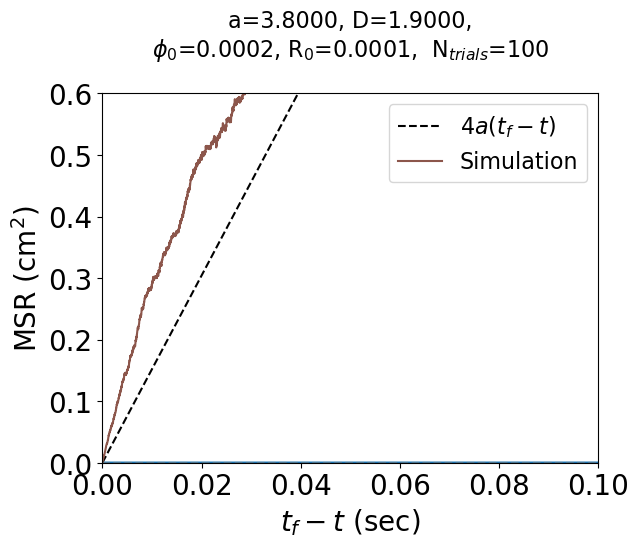

In [36]:
#estimated run time: 11 minutes


# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"



print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt
# x_values=aligned_mean_values[:,0]
# plt.plot(aligned_mean_values[:,1])
# plt.plot(aligned_mean_values[:,2])
# plt.plot(aligned_mean_values[:,3])

xmin,xmax=0,0.1
ymin,ymax=0,0.6
xv=np.linspace(xmin,xmax,100)
plt.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(t_values,MSR_values,c='C5',label=r"Simulation")
# plt.plot(t_values,aligned_mean_values[::-1,0]**2)
plt.plot(t_values,t_values*0.,'--',c='gray',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.title(title,fontsize=16)
plt.legend(fontsize=16)
plt.show()




In [37]:

boo=~(np.isnan(t_values)|np.isnan(MSR_values))
dict_fit=compute_95CI_ols(t_values[boo],MSR_values[boo])
print_dict(dict_fit)
print(f"num_samples={positions_out.shape[-1]}")
print(f"num_timepoints={t_values.shape[0]}")
print(f"ahat = {dict_fit['m']/4:.4f}+/-{dict_fit['Delta_m']/4:.4f}")

m=15.687366825275118
Delta_m=0.006563160827167656
b=-0.09775733309437928
Delta_b=0.003789214250968185
Rsquared=0.9954644400547724
num_samples=100
num_timepoints=100000
ahat = 3.9218+/-0.0016


In [38]:
#TODO: recall my Nelder-Mead least-squares minimization routine
#TODO: merge ^those two routines
#TODO: plot the MSR of the resulting fit (if Nelder-Mead is sufficiently awesome)

In [39]:
meanT_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/luorudy_mean_kinematic_periods.npz'
meanT_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/fentonkarma_mean_kinematic_periods.npz'
np.mean(meanT_values)

NameError: name 'meanT_values' is not defined